In [5]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src
sys.path.insert(1, os.path.join(sys.path[0], '../'))  # for importing model config

%reload_ext autoreload
%autoreload 2 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

## Loading Scores

In [9]:
# hs_scores = pd.read_csv('../results_hydroshoot_base_full_360_res.csv', index_col=0)
hs_scores = pd.read_csv('results_hydroshoot_input_phys_16sample.csv', index_col=0)
cn_scores = pd.read_csv('results_cnwheat_input_phys_16sample.csv', index_col=0)

In [10]:
cn_scores.head()

,target_id,reservoir_id,dataset_id,test_score,train_mean,train_std,cv_mean,cv_std,state_sample
0,input_air_temperature,state__An,NEMA_combined,-0.290477,-0.218761,0.005905,-0.803800,0.675349,0
1,input_air_temperature,state__Ts,NEMA_combined,-0.045537,-0.044375,0.001530,-0.141982,0.058604,0
2,input_air_temperature,state__gs,NEMA_combined,-0.413302,-0.375427,0.014975,-1.562506,1.772772,0
3,input_air_temperature,state__Tr,NEMA_combined,-0.294481,-0.194566,0.009701,-0.995355,0.925679,0
4,input_humidity,state__An,NEMA_combined,-0.696766,-0.523030,0.017132,-1.968814,3.297654,0


In [11]:
hs_scores.head()

,target_id,reservoir_id,dataset_id,test_score,train_mean,train_std,cv_mean,cv_std,state_sample
0,input_Tac,state_An,HydroShoot_large,-0.417873,-0.423934,0.009412,-0.490868,0.050836,0
1,input_Tac,state_Tlc,HydroShoot_large,-0.234559,-0.202517,0.005272,-0.222941,0.032507,0
2,input_Tac,state_gs,HydroShoot_large,-0.419141,-0.427197,0.010967,-0.507733,0.058518,0
3,input_Tac,state_E,HydroShoot_large,-0.356066,-0.358567,0.006332,-0.407803,0.041125,0
4,input_Tac,state_Flux,HydroShoot_large,-0.357783,-0.356200,0.006389,-0.409552,0.039481,0


### Data normalization

In [12]:
cn_scores.target_id.unique()

array(['input_air_temperature', 'input_humidity', 'input_PARi',
       'output__axes__Total_Transpiration',
       'output__axes__sum_respi_roots', 'output__axes__sum_respi_shoot',
       'output__custom__PARa'], dtype=object)

In [13]:
output_names = [
  'output0_E',
  'output1_absorbed_solar',
  'output2_An',
]

hs_output_map = {
  'output_E': 'output0_E',
  'output_Rg': 'output1_absorbed_solar',
  'output_An': 'output2_An',
}

cn_output_map = {
  'output__axes__Total_Transpiration': 'output0_E',
  'output__custom__PARa': 'output1_absorbed_solar',
}

hs_scores.target_id = hs_scores.target_id.apply(lambda x: hs_output_map[x] if x in hs_output_map else x)
cn_scores.target_id = cn_scores.target_id.apply(lambda x: cn_output_map[x] if x in cn_output_map else x)

input_names = [
  'input0_temp',
  'input1_rh',
  'input2_solar',
]

hs_input_map = {
  'input_Tac': 'input0_temp',
  'input_hs': 'input1_rh',
  'input_Rg': 'input2_solar',
}

cn_input_map = {
  "input_air_temperature": 'input0_temp',
  "input_humidity": 'input1_rh',
  "input_PARi": 'input2_solar',
}

hs_scores.target_id = hs_scores.target_id.apply(lambda x: hs_input_map[x] if x in hs_input_map else x)
cn_scores.target_id = cn_scores.target_id.apply(lambda x: cn_input_map[x] if x in cn_input_map else x)

In [14]:
hs_reservoir_names = ['state_An', 'state_Ts', 'state_gs', 'state_E', 'state_Flux', 'state_psi_head']
cn_reservoir_names = ['state_An', 'state_Ts', 'state_gs', 'state_E']

cn_scores.reservoir_id = cn_scores.reservoir_id.apply(lambda x : x.replace('__', '_'))
cn_scores.reservoir_id = cn_scores.reservoir_id.apply(lambda x : x.replace('state_Tr', 'state_E'))
hs_scores.reservoir_id = hs_scores.reservoir_id.apply(lambda x : x.replace('state_Tlc', 'state_Ts'))

In [15]:
cn_scores.dataset_id = 'CN-Wheat'
hs_scores.dataset_id = 'HydroShoot'

## Figures

### Boxplots

In [16]:
cn_regression_scores = cn_scores.loc[cn_scores.target_id.isin(input_names + output_names)]
cn_regression_scores = cn_regression_scores.sort_values(['target_id', 'reservoir_id'])

hs_regression_scores = hs_scores.loc[hs_scores.target_id.isin(input_names + output_names)]
hs_regression_scores = hs_regression_scores.sort_values(['target_id', 'reservoir_id'])

regression_scores = pd.concat([cn_regression_scores, hs_regression_scores])
regression_scores.test_score *= -1

In [17]:
res_symbols = {
  'state_An': r'\textbf{Net photosynthesis rate ($\boldsymbol{A_n}$)}',
  'state_Ts': r'\textbf{Surface temperature ($\boldsymbol{T_s}$)}',
  'state_gs': r'\textbf{Stomatal conductance ($\boldsymbol{g_s}$)}',
  'state_E': r'\textbf{Transpiration rate ($\boldsymbol{E}$)}',
  'state_Flux': r'\textbf{Water flow ($\boldsymbol{F}$)}',
  'state_psi_head': r'\textbf{Hydraulic potential ($\boldsymbol{\Psi}$)}',
}

# res_symbols = {
#   'state_An': r'$A_n$',
#   'state_Ts': r'$T_s$',
#   'state_gs': r'$g_s$',
#   'state_E': r'$E$',
#   'state_Flux': r'$F$',
#   'state_psi_head': r'$\Psi$',
# }
# res_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in res_symbols.items()}


input_symbols = {
  'input0_temp': r'$T_{\text{air}}$',
  'input1_rh': r'RH',
  'input2_solar': r'PAR',
  # 'input2_solar': r'$R_g$/$I_{\text{PAR}}$',
}

input_symbols_hs = {
  'input0_temp': r'$T_{\text{air}}$',
  'input1_rh': r'RH',
  'input2_solar': r'PAR',
  # 'input2_solar': r'$R_g$',
}

output_symbols = {
  'output0_E': r'$E$',
  # 'output1_absorbed_solar': r'$\Phi_{R_g}$/$\Phi_{I_{\text{PAR}}}$',
  'output1_absorbed_solar': r'$\Phi_{\text{PAR}}$',
  'output2_An': r'$A_n$',
}

output_symbols_hs = {
  'output0_E': r'$E$',
  # 'output1_absorbed_solar': r'$\Phi_{R_g}$',
  'output1_absorbed_solar': r'$\Phi_{\text{PAR}}$',
  'output2_An': r'$A_n$',
}

target_symbols = {**input_symbols, **output_symbols}
target_symbols_hs = {**input_symbols_hs, **output_symbols_hs}


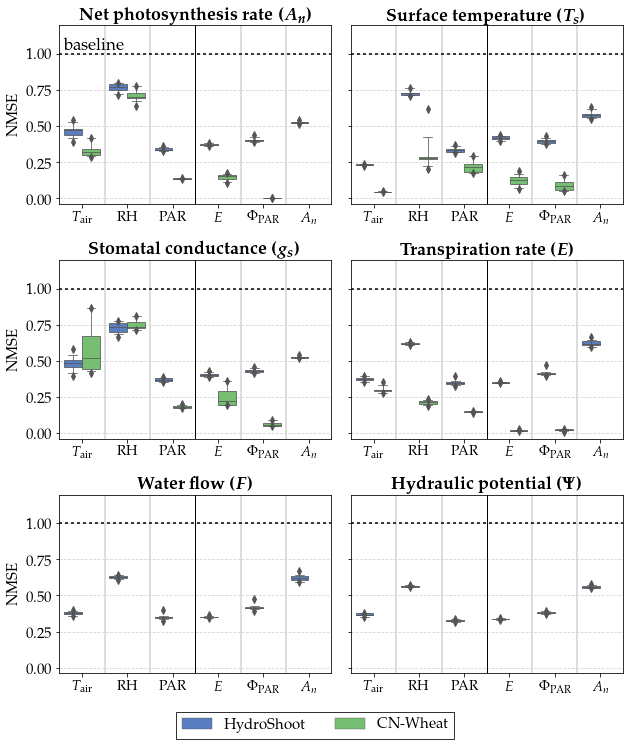

In [43]:
with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharey=True)
  colors = sns.color_palette()

  for res, ax in zip(hs_reservoir_names, axs.flatten()):

    # Data plotting
    plot_data = regression_scores.loc[regression_scores.reservoir_id == res]
    plot_box = lambda order : sns.boxplot(data=plot_data, x='target_id', y='test_score', hue='dataset_id', ax=ax,
                                          linewidth=0.75, hue_order=order, order=target_symbols_hs.keys(), whis=[5, 95])

    _ax = plot_box(['HydroShoot', ''])
    _ax = plot_box(['', 'CN-Wheat'])


    # Labeling
    if res in ['state_Flux', 'state_psi_head']:
      ax.set_xticklabels(list(target_symbols_hs.values()), fontsize=14)
    else:
      ax.set_xticklabels(list(target_symbols.values()), fontsize=14)
    ax.set_title(res_symbols[res], fontsize=18)
    if ax in axs.flatten()[::2]:
      ax.set_ylabel('NMSE')
    else:
      ax.set(ylabel=None)
    if ax is axs.flatten()[0]:
      ax.annotate('baseline', (0.015, 0.86), fontsize=17, xycoords='axes fraction')

    # Axes
    ax.set_ylim(top=1.2)
    ax.set_axisbelow(True)
    # ax.set_xticks(np.arange(0, 5) + 0.5)
    ax.yaxis.grid(color='lightgrey', linestyle='dashed')
    # ax.xaxis.grid(color='lightgrey', linestyle='solid', linewidth=1.25)
    for x in (np.arange(0, 5) + 0.5):
      if x == 2.5:
        ax.axvline(x, color='black', linewidth=1)
      else:
        ax.axvline(x, color='lightgrey')
    ax.axhline(1, color='black', dashes=(2,2))

    # Cleanup
    if ax is axs.flatten()[0]:
      fig.legend(loc='lower center', fancybox=False, shadow=False, ncol=5, 
                 frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.05), fontsize=15)
    ax.get_legend().remove()
    ax.set(xlabel=None)

  plt.tight_layout()
  plt.savefig('regression_res_perf.png', dpi=200, facecolor='white', bbox_inches='tight')

## 3x2 

In [31]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedFormatter, FixedLocator)

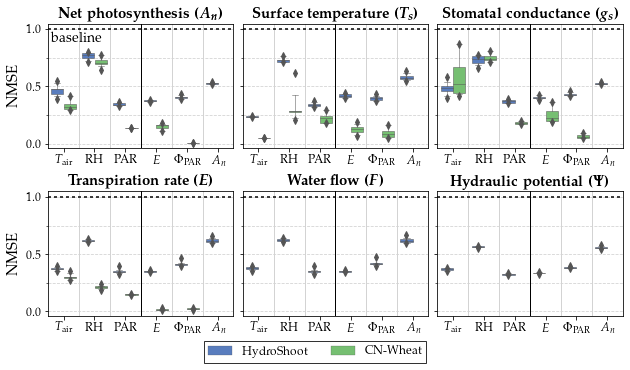

In [74]:
with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(2, 3, figsize=(9, 5), sharey=True)
  colors = sns.color_palette()

  for res, ax in zip(hs_reservoir_names, axs.flatten()):

    # Data plotting
    plot_data = regression_scores.loc[regression_scores.reservoir_id == res]
    plot_box = lambda order : sns.boxplot(data=plot_data, x='target_id', y='test_score', hue='dataset_id', ax=ax,
                                          linewidth=0.5, hue_order=order, order=target_symbols_hs.keys(), whis=[5, 95])

    _ax = plot_box(['HydroShoot', ''])
    _ax = plot_box(['', 'CN-Wheat'])


    # Labeling
    if res in ['state_Flux', 'state_psi_head']:
      ax.set_xticklabels(list(target_symbols_hs.values()), fontsize=14)
    else:
      ax.set_xticklabels(list(target_symbols.values()), fontsize=14)
    ax.set_title(res_symbols[res], fontsize=15)
    if ax in axs.flatten()[::3]:
      ax.set_ylabel('NMSE')
    else:
      ax.set(ylabel=None)
    if ax is axs.flatten()[0]:
      ax.annotate('baseline', (0.013, 0.85), fontsize=14, xycoords='axes fraction')

    # Axes
    ax.set_ylim(top=1.05)
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(MultipleLocator(.5))
    ax.yaxis.set_minor_locator(MultipleLocator(.25))
    ax.grid(axis='y', linestyle='dashed', color='lightgrey', which='both')
    ax.tick_params(axis='both', which='both', labelsize=12)
    # ax.yaxis.grid(color='lightgrey', linestyle='dashed')
    # ax.xaxis.grid(color='lightgrey', linestyle='solid', linewidth=1.25)
    for x in (np.arange(0, 5) + 0.5):
      if x == 2.5:
        ax.axvline(x, color='black', linewidth=1)
      else:
        ax.axvline(x, color='lightgrey', linewidth=1)
    ax.axhline(1, color='black', dashes=(2,2))

    # Cleanup
    if ax is axs.flatten()[0]:
      fig.legend(loc='lower center', fancybox=False, shadow=False, ncol=5, 
                 frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.05), fontsize=12)
    ax.get_legend().remove()
    ax.set(xlabel=None)

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.05, hspace=0.35)  
  plt.savefig('regression_res_perf_compact.png', dpi=200, facecolor='white', bbox_inches='tight')

### 2x3 vertical

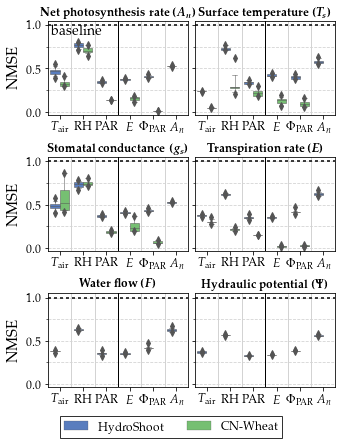

In [65]:
with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(3, 2, figsize=(5, 6), sharey=True)
  colors = sns.color_palette()

  for res, ax in zip(hs_reservoir_names, axs.flatten()):

    # Data plotting
    plot_data = regression_scores.loc[regression_scores.reservoir_id == res]
    plot_box = lambda order : sns.boxplot(data=plot_data, x='target_id', y='test_score', hue='dataset_id', ax=ax,
                                          linewidth=0.5, hue_order=order, order=target_symbols_hs.keys(), whis=[5, 95])

    _ax = plot_box(['HydroShoot', ''])
    _ax = plot_box(['', 'CN-Wheat'])


    # Labeling
    if res in ['state_Flux', 'state_psi_head']:
      ax.set_xticklabels(list(target_symbols_hs.values()), fontsize=14)
    else:
      ax.set_xticklabels(list(target_symbols.values()), fontsize=14)
    ax.set_title(res_symbols[res], fontsize=13)
    if ax in axs.flatten()[::2]:
      ax.set_ylabel('NMSE')
    else:
      ax.set(ylabel=None)
    if ax is axs.flatten()[0]:
      ax.annotate('baseline', (0.013, 0.85), fontsize=14, xycoords='axes fraction')

    # Axes
    ax.set_ylim(top=1.05)
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(MultipleLocator(.5))
    ax.yaxis.set_minor_locator(MultipleLocator(.25))
    ax.grid(axis='y', linestyle='dashed', color='lightgrey', which='both')
    ax.tick_params(axis='both', which='both', labelsize=12)
    # ax.yaxis.grid(color='lightgrey', linestyle='dashed')
    # ax.xaxis.grid(color='lightgrey', linestyle='solid', linewidth=1.25)
    for x in (np.arange(0, 5) + 0.5):
      if x == 2.5:
        ax.axvline(x, color='black', linewidth=1)
      else:
        ax.axvline(x, color='lightgrey', linewidth=1)
    ax.axhline(1, color='black', dashes=(2,2))

    # Cleanup
    if ax is axs.flatten()[0]:
      fig.legend(loc='lower center', fancybox=False, shadow=False, ncol=5, 
                 frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.05), fontsize=12)
    ax.get_legend().remove()
    ax.set(xlabel=None)

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.05, hspace=0.45)  
  plt.savefig('regression_res_perf_compact_vert.png', dpi=200, facecolor='white', bbox_inches='tight')

### Results page

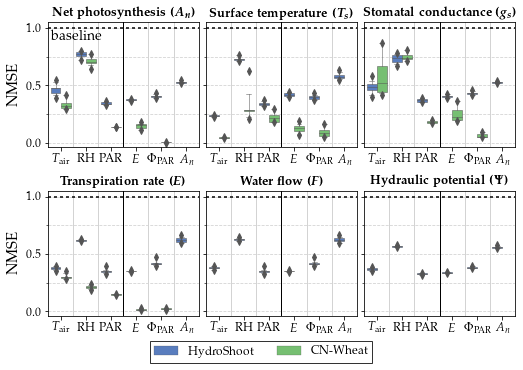

In [87]:
res_symbols = {
  'state_An': r'\textbf{Net photosynthesis ($\boldsymbol{A_n}$)}',
  'state_Ts': r'\textbf{Surface temperature ($\boldsymbol{T_s}$)}',
  'state_gs': r'\textbf{Stomatal conductance ($\boldsymbol{g_s}$)}',
  'state_E': r'\textbf{Transpiration rate ($\boldsymbol{E}$)}',
  'state_Flux': r'\textbf{Water flow ($\boldsymbol{F}$)}',
  'state_psi_head': r'\textbf{Hydraulic potential ($\boldsymbol{\Psi}$)}',
}

# res_symbols = {
#   'state_An': r'$A_n$',
#   'state_Ts': r'$T_s$',
#   'state_gs': r'$g_s$',
#   'state_E': r'$E$',
#   'state_Flux': r'$F$',
#   'state_psi_head': r'$\Psi$',
# }
# res_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in res_symbols.items()}


input_symbols = {
  'input0_temp': r'$T_{\text{air}}$',
  'input1_rh': r'RH',
  'input2_solar': r'PAR',
  # 'input2_solar': r'$R_g$/$I_{\text{PAR}}$',
}

input_symbols_hs = {
  'input0_temp': r'$T_{\text{air}}$',
  'input1_rh': r'RH',
  'input2_solar': r'PAR',
  # 'input2_solar': r'$R_g$',
}

output_symbols = {
  'output0_E': r'$E$',
  # 'output1_absorbed_solar': r'$\Phi_{R_g}$/$\Phi_{I_{\text{PAR}}}$',
  'output1_absorbed_solar': r'$\Phi_{\text{PAR}}$',
  'output2_An': r'$A_n$',
}

output_symbols_hs = {
  'output0_E': r'$E$',
  # 'output1_absorbed_solar': r'$\Phi_{R_g}$',
  'output1_absorbed_solar': r'$\Phi_{\text{PAR}}$',
  'output2_An': r'$A_n$',
}

target_symbols = {**input_symbols, **output_symbols}
target_symbols_hs = {**input_symbols_hs, **output_symbols_hs}


with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(2, 3, figsize=(7.5, 5), sharey=True)
  colors = sns.color_palette()

  for res, ax in zip(hs_reservoir_names, axs.flatten()):

    # Data plotting
    plot_data = regression_scores.loc[regression_scores.reservoir_id == res]
    plot_box = lambda order : sns.boxplot(data=plot_data, x='target_id', y='test_score', hue='dataset_id', ax=ax,
                                          linewidth=0.5, hue_order=order, order=target_symbols_hs.keys(), whis=[5, 95])

    _ax = plot_box(['HydroShoot', ''])
    _ax = plot_box(['', 'CN-Wheat'])


    # Labeling
    if res in ['state_Flux', 'state_psi_head']:
      ax.set_xticklabels(list(target_symbols_hs.values()), fontsize=14)
    else:
      ax.set_xticklabels(list(target_symbols.values()), fontsize=14)
    ax.set_title(res_symbols[res], fontsize=13)
    if ax in axs.flatten()[::3]:
      ax.set_ylabel('NMSE')
    else:
      ax.set(ylabel=None)
    if ax is axs.flatten()[0]:
      ax.annotate('baseline', (0.013, 0.85), fontsize=14, xycoords='axes fraction')

    # Axes
    ax.set_ylim(top=1.05)
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(MultipleLocator(.5))
    ax.yaxis.set_minor_locator(MultipleLocator(.25))
    ax.grid(axis='y', linestyle='dashed', color='lightgrey', which='both')
    ax.tick_params(axis='both', which='both', labelsize=12)
    for x in (np.arange(0, 5) + 0.5):
      if x == 2.5:
        ax.axvline(x, color='black', linewidth=1)
      else:
        ax.axvline(x, color='lightgrey', linewidth=1)
    ax.axhline(1, color='black', dashes=(2,2))

    # Cleanup
    if ax is axs.flatten()[0]:
      fig.legend(loc='lower center', fancybox=False, shadow=False, ncol=5,
                 frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.05), fontsize=12)
    ax.get_legend().remove()
    ax.set(xlabel=None)

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.05, hspace=0.35)  
  plt.savefig('regression_res_perf_compact.png', dpi=200, facecolor='white', bbox_inches='tight')